<a href="https://colab.research.google.com/github/Sanket758/Machine-Learning-Projects/blob/master/Customer_Segmantation_using_KMeans_and_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Data Source: https://www.kaggle.com/kyanyoga/sample-sales-data*

In [1]:
import os
import PIL
from PIL import *
import cv2

import pandas as pd
import numpy as np
    
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from IPython.display import display
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

from google.colab.patches import cv2_imshow
%matplotlib inline

In [3]:
# Load the dataset
sales = pd.read_csv('sales_data_sample.csv', encoding='unicode_escape')
print(sales.shape)

(2823, 25)


In [4]:
sales.head() #check first 5 rows

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [5]:
sales.info() # check out datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  PHONE             2823 non-null   object 
 15  ADDRESSLINE1      2823 non-null   object 
 16  ADDRESSLINE2      302 non-null    object 


In [6]:
# Changing the order date column to a proper datetime format
sales.ORDERDATE = pd.to_datetime(sales.ORDERDATE)
sales.ORDERDATE.dtype

dtype('<M8[ns]')

In [7]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

In [8]:
# Null check
sales.isna().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [9]:
# Dropping unwanted columns
drop_cols = ['CUSTOMERNAME' ,'PHONE','ADDRESSLINE1','ADDRESSLINE2',
             'CITY','STATE','POSTALCODE','TERRITORY',
             'CONTACTLASTNAME','CONTACTFIRSTNAME','ORDERNUMBER' ]
sales = sales.drop(drop_cols,axis=1)
sales.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,S10_1678,USA,Medium


In [10]:
sales.isna().sum()

QUANTITYORDERED    0
PRICEEACH          0
ORDERLINENUMBER    0
SALES              0
ORDERDATE          0
STATUS             0
QTR_ID             0
MONTH_ID           0
YEAR_ID            0
PRODUCTLINE        0
MSRP               0
PRODUCTCODE        0
COUNTRY            0
DEALSIZE           0
dtype: int64

In [11]:
sales.COUNTRY.unique() # Will tell you how many countries in data coming from

array(['USA', 'France', 'Norway', 'Australia', 'Finland', 'Austria', 'UK',
       'Spain', 'Sweden', 'Singapore', 'Canada', 'Japan', 'Italy',
       'Denmark', 'Belgium', 'Philippines', 'Germany', 'Switzerland',
       'Ireland'], dtype=object)

In [12]:
len(sales.COUNTRY.unique()) #19 different countries

19

In [13]:
sales.PRODUCTCODE.unique(), len(sales.PRODUCTCODE.unique()) 

(array(['S10_1678', 'S10_1949', 'S10_2016', 'S10_4698', 'S10_4757',
        'S10_4962', 'S12_1099', 'S12_1108', 'S12_1666', 'S12_2823',
        'S12_3148', 'S12_3380', 'S12_3891', 'S12_3990', 'S12_4473',
        'S12_4675', 'S18_1097', 'S18_1129', 'S18_1342', 'S18_1367',
        'S18_1589', 'S18_1662', 'S18_1749', 'S18_1889', 'S18_1984',
        'S18_2238', 'S18_2248', 'S18_2319', 'S18_2325', 'S18_2432',
        'S18_2581', 'S18_2625', 'S18_2795', 'S18_2870', 'S18_2949',
        'S18_2957', 'S18_3029', 'S18_3136', 'S18_3140', 'S18_3232',
        'S18_3259', 'S18_3278', 'S18_3320', 'S18_3482', 'S18_3685',
        'S18_3782', 'S18_3856', 'S18_4027', 'S18_4409', 'S18_4522',
        'S18_4600', 'S18_4668', 'S18_4721', 'S18_4933', 'S24_1046',
        'S24_1444', 'S24_1578', 'S24_1628', 'S24_1785', 'S24_1937',
        'S24_2000', 'S24_2011', 'S24_2022', 'S24_2300', 'S24_2360',
        'S24_2766', 'S24_2840', 'S24_2841', 'S24_2887', 'S24_2972',
        'S24_3151', 'S24_3191', 'S24_3371', 'S24

109 different product codes found


# Exploratory Data Analysis

In [14]:
# Visualization of products in every country
def barplot_vis(x):
    fig = plt.Figure(figsize=(12,6))
    fig = px.bar(x=sales[x].value_counts().index, y=sales[x].value_counts(), color=sales[x].value_counts().index, height=500)
    fig.show();

In [15]:
barplot_vis('COUNTRY')

In [16]:
barplot_vis('STATUS')

**This shows that our status column is highly unbalanced**

In [17]:
# Removing the status column
sales.drop(columns=['STATUS'], inplace=True)

In [18]:
barplot_vis('PRODUCTLINE') # Checking different products

In [19]:
barplot_vis('DEALSIZE')

Again an unbalanced column

In [20]:
def dummies(x):
    dummy = pd.get_dummies(sales[x])
    sales.drop(columns=x, inplace=True)
    return pd.concat([sales, dummy], axis=1)

In [21]:
# lets obtain dummy variables for column country
sales = dummies('COUNTRY')
sales.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,DEALSIZE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,S10_1678,Small,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,S10_1678,Small,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,S10_1678,Medium,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,S10_1678,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,S10_1678,Medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [22]:
# Getting dummies for other categorical collumns as well
sales = dummies('PRODUCTLINE')
sales = dummies('DEALSIZE')

In [23]:
# Sanity check
sales.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0


In [24]:
# Label Encoding Product code collumn, here we are not one hot encoding to avoid curse of dimensionality
sales.PRODUCTCODE = pd.Categorical(sales.PRODUCTCODE).codes

# Sanity check
sales.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0


In [26]:
# Grouping data by order date
sales_group = sales.groupby(by='ORDERDATE').sum()
sales_group

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
ORDERDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-01-06,151,288.78,10,12133.25,4,4,8012,363,174.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,4,0,2,2
2003-01-09,142,284.96,10,11432.34,4,4,8012,372,181.0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,2,2
2003-01-10,80,150.14,3,6864.05,2,2,4006,155,37.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,2,0,1,1
2003-01-29,541,1417.54,136,54702.00,16,16,32048,1695,723.0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,3,0,0,0,0,7,6,0,10,6
2003-01-31,443,1061.89,91,44621.96,13,13,26039,1365,720.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0,7,0,0,0,2,4,0,0,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-13,259,561.18,21,31821.90,12,30,12030,728,101.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,6,0,0,0,0,0,2,3,1
2005-05-17,509,1269.43,105,59475.10,28,70,28070,1669,462.0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,2,8,4
2005-05-29,607,1148.40,94,51233.18,30,75,30075,1328,797.0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,7,0,0,0,0,0,8,0,8,7


In [37]:
# Month wise sales data - when does sales peak?
sales_month_wise = sales.groupby(by='MONTH_ID')['SALES'].sum()
fig = px.line(x=sales_month_wise.index ,y=sales_month_wise, title='Month wise sales')
fig.show();

In [38]:
# We can drop 'ORDERDATE' because we already have other date related columns like month_id
sales.drop(columns=['ORDERDATE'], axis=1, inplace=True)
sales.shape

(2823, 38)

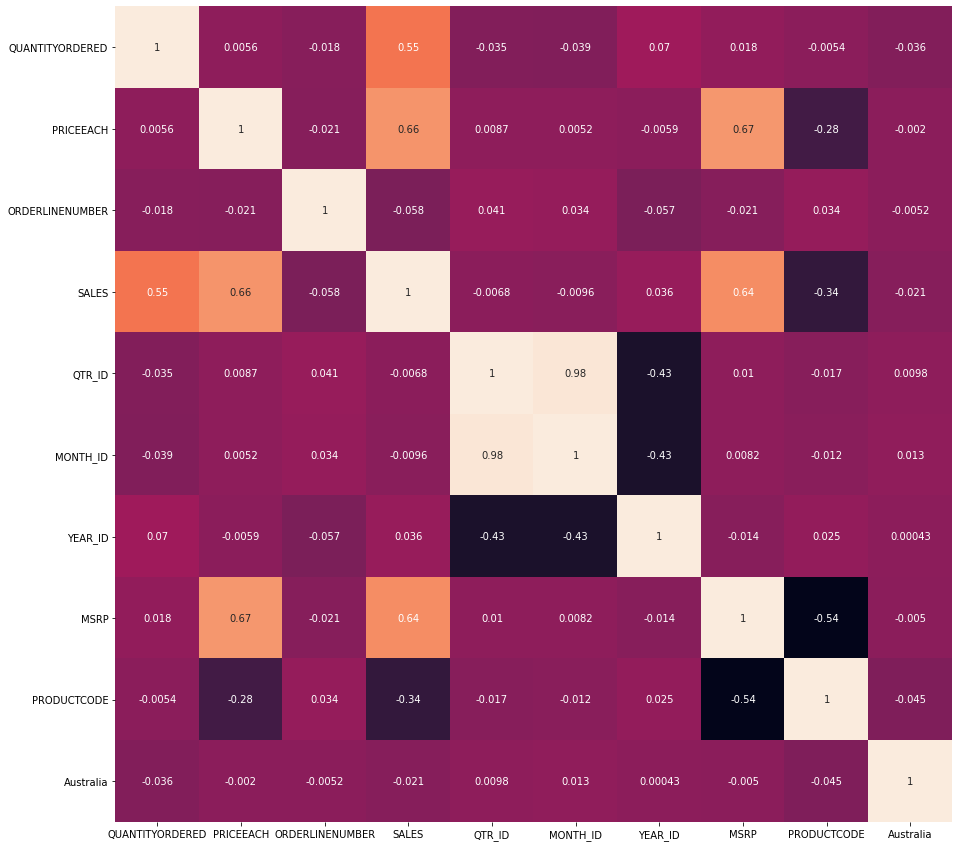

In [42]:
plt.figure(figsize=(15,15))
# Plotting correlation matrix for all the columns except one hot encoded cols
sns.heatmap(sales.iloc[:,:10].corr(), annot=True, cbar=False);

Observations:  
1. Quantity ordered and sales has a positive correlation of 0.55  
2. MSRP has a positive correlation of 0.64, which is obious that if MSRP increases sales also increase
3. Month ID and QTR_ID are extremely correlated. which means that you can drop one of these columns and it wont affect your predictions. They represent the same information to our model.

In [43]:
# Droping QTR_ID column
sales.drop('QTR_ID', axis=1, inplace=True)
#sanity check
sales.shape

(2823, 37)

In [48]:
# Creating Distribution plots
import plotly.figure_factory as ff
plt.figure(figsize=(10,10))

for i in range(8):
    if sales.columns[i] != 'OREDERLINE':
        fig = ff.create_distplot([sales[sales.columns[i]].apply(lambda x: float(x))], ['distplot'])
        fig.update_layout(title_text=sales.columns[i])
        fig.show();

<Figure size 720x720 with 0 Axes>

In [49]:
# Creating pair plots
plt.figure(figsize=(15,15))
fig = px.scatter_matrix(sales,
                        dimensions=sales.columns[:8],
                        color='MONTH_ID')

fig.update_layout(
    title='Sale Data',
    width=1100,
    height=1100
)
fig.show()

<Figure size 1080x1080 with 0 Axes>

**Observations:**  
    1. There is a trend between 'SALES' and 'QUANTITYORDERED'  
    2. Trend between 'MSRP' and 'PRICEEACH'  
    3. Trend between 'PRICEEACH' and 'SALES'  
    4. Sales grows exist as year increase from 2013, 2014, 2015

# KMeans Clustering Algorithms  

 **K-Means** is one of the most popular "clustering" algorithms. K-means stores k centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid.

K-Means finds the best centroids by alternating between   
    (1) assigning data points to clusters based on the current centroids   
    (2) chosing centroids (points which are the center of a cluster) based on the current assignment of data points to clusters. 

# Find the optimal number of clusters using Elbow method

The **elbow method** is a heuristic method of interpretation and validation of consistency within cluster analysis designed to help find the appropriate number of clusters in a dataset.


In [50]:
# Scale the data
scaler = StandardScaler()
scaled_sales = scaler.fit_transform(sales)

In [51]:
sales.shape

(2823, 37)

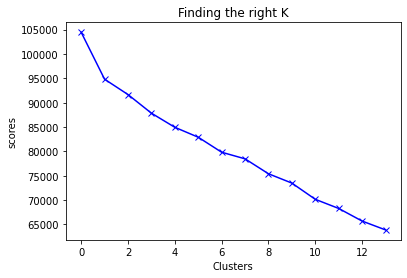

In [53]:
# Elbow method
scores = []

# from k=1 to k=15
for i in range(1,15):
    kmeans = KMeans(n_clusters=i) #creating KMeans object
    kmeans.fit(scaled_sales) # Fitting kmeans to scaled dataset
    # Inertia is the sum of squares distances within clusters
    scores.append(kmeans.inertia_) #store the inertias in scores

plt.plot(scores, 'bx-')
plt.title('Finding the right K')
plt.xlabel('Clusters')
plt.ylabel('scores')
plt.show();    

After k=5, graph looks linear so we will choose K=5 for now. But we can't actually apply elbow method here.

# Apply K-Means Method

In [54]:
# Cluster the data using K-means with K=5
kmeans = KMeans(5)
kmeans.fit(scaled_sales)
labels = kmeans.labels_

In [55]:
labels

array([3, 3, 4, ..., 1, 1, 1], dtype=int32)

In [56]:
kmeans.cluster_centers_.shape

(5, 37)

We have K=5 and 37 columns in our dataset thats why there are cluster centers with (5,37) shape

In [58]:
# Lets take a look at the cluster centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_,
                               columns=[sales.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,1.245428,0.800220,-0.259579,2.573861,-0.088008,0.136857,1.430265,-0.871802,-0.084647,0.043374,-0.108756,-0.118498,0.107642,-0.004181,0.071653,0.023985,0.094193,0.023250,0.005118,0.010166,-0.029737,-0.015199,-0.039435,-0.052984,-0.105371,-0.116045,0.108611,0.580097,0.011712,-0.164278,-0.300637,-0.128350,-0.201008,-0.151285,4.120788,-0.980703,-0.912100
1,-0.031214,0.015398,0.074318,-0.267357,-0.047689,-0.006784,-0.363873,1.123812,-0.264819,-0.016217,0.332363,0.228602,0.257449,0.034938,-0.065874,-0.091032,-0.075499,-0.072267,0.023289,-0.176195,-0.096414,-0.065138,0.143904,0.162897,-0.105371,0.218748,-0.112648,-0.721812,-0.364452,-0.348674,3.326275,-0.167454,-0.345470,-0.523371,-0.242672,-0.066737,0.178707
2,-0.173920,-0.039573,-0.005290,-0.189818,0.073057,-0.000691,-0.072337,-0.135140,3.776170,-0.140961,-0.108756,-0.159458,-0.151083,-0.183541,-0.353765,-0.149852,-0.075499,-0.204199,-0.136988,-0.176195,-0.096414,-0.169676,-0.371278,-0.143553,-0.105371,-0.231843,-0.742934,-0.118060,0.054645,0.103108,-0.259885,-0.132964,0.000380,0.242402,-0.242672,-0.014228,0.125986
3,-0.459396,-0.776833,0.037814,-0.825764,0.007359,0.003686,-0.593776,0.200716,-0.264819,-0.018562,-0.021316,0.015815,-0.036554,0.012306,0.046787,0.023291,0.024658,0.078677,0.051730,0.032796,0.011811,0.035471,0.008926,-0.009913,-0.024206,0.011644,0.030605,-0.094005,0.047456,0.119922,-0.300637,0.115275,-0.007455,0.142336,-0.242672,-0.980703,1.096370
4,0.278074,0.590928,-0.013239,0.478466,0.003395,-0.019893,0.423256,-0.262884,-0.264819,0.035062,-0.015096,-0.019191,-0.009096,0.010174,0.014448,0.016146,-0.008448,-0.028733,-0.030925,0.029991,0.026536,0.008355,0.024661,0.005559,0.071729,-0.003063,0.091243,0.165622,0.018870,-0.032942,-0.300637,-0.033544,0.100312,-0.041459,-0.242672,1.019676,-0.912100


Opps! Data is scaled......

In [60]:
# Do the inverse transformation
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(cluster_centers,
                               columns=[sales.columns])
cluster_centers 

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,47.222930,99.799554,5.369427,8293.753248,6.770701,2003.910828,158.184713,26.242038,4.458599e-02,2.547771e-02,-1.908196e-17,6.369427e-03,3.821656e-02,3.184713e-02,1.337580e-01,2.547771e-02,1.273885e-02,4.458599e-02,1.910828e-02,3.184713e-02,6.369427e-03,2.547771e-02,1.082803e-01,1.273885e-02,4.336809e-17,2.547771e-02,4.076433e-01,6.178344e-01,1.210191e-01,5.732484e-02,-1.110223e-16,6.369427e-03,0.044586,1.528662e-01,1.000000e+00,-7.771561e-16,9.992007e-16
1,34.788793,83.969138,6.780172,3061.540388,6.918103,2003.810345,86.094828,89.262931,-4.024558e-16,1.724138e-02,4.741379e-02,6.034483e-02,6.034483e-02,3.879310e-02,9.051724e-02,8.620690e-03,-1.908196e-17,2.586207e-02,2.155172e-02,1.075529e-16,3.642919e-17,1.724138e-02,1.681034e-01,4.310345e-02,5.724587e-17,9.913793e-02,3.017241e-01,1.665335e-16,-4.579670e-16,-1.387779e-17,1.000000e+00,-1.318390e-16,0.000000,5.551115e-16,-1.942890e-16,4.568966e-01,5.431034e-01
2,33.398876,82.860337,6.443820,3204.331798,7.359551,2003.814607,97.808989,49.505618,1.000000e+00,-6.245005e-17,-3.469447e-18,4.163336e-17,-9.367507e-17,-6.245005e-17,9.714451e-17,-4.857226e-17,-1.214306e-17,3.469447e-17,5.551115e-17,1.006140e-16,0.000000e+00,-5.551115e-17,-2.359224e-16,5.204170e-17,4.857226e-17,-1.387779e-16,8.881784e-16,2.865169e-01,1.348315e-01,1.404494e-01,1.123596e-02,5.617978e-03,0.106742,3.146067e-01,-1.595946e-16,4.831461e-01,5.168539e-01
3,30.618421,67.989286,6.625940,2033.212961,7.119361,2003.817669,76.857143,60.111842,6.106227e-16,1.691729e-02,9.398496e-03,2.725564e-02,1.691729e-02,3.477444e-02,1.259398e-01,2.537594e-02,7.518797e-03,5.545113e-02,2.537594e-02,3.571429e-02,1.033835e-02,3.383459e-02,1.240602e-01,1.879699e-02,8.458647e-03,5.357143e-02,3.703008e-01,2.979323e-01,1.325188e-01,1.456767e-01,-1.387779e-16,4.605263e-02,0.104323,2.734962e-01,8.812395e-16,-1.054712e-15,1.000000e+00
4,37.801174,95.577987,6.410235,4435.002156,7.104866,2003.801174,117.722315,45.471477,6.383782e-16,2.432886e-02,1.006711e-02,2.181208e-02,2.097315e-02,3.439597e-02,1.157718e-01,2.432886e-02,5.033557e-03,3.439597e-02,1.426174e-02,3.523490e-02,1.174497e-02,2.936242e-02,1.291946e-01,2.097315e-02,1.845638e-02,5.033557e-02,3.993289e-01,4.211409e-01,1.233221e-01,9.815436e-02,-7.632783e-16,2.181208e-02,0.137584,1.979866e-01,2.220446e-16,1.000000e+00,-7.327472e-15


**Observations**  
    1. We have 5 different clusters, and above 5 points represent 5 centroids of those clusters   
    2. Cluster 1 - This group represents the customers who have highest Quantity ordered, as well as they spend around $99 on each item and MSRP is also highest. SALES value for these customers is highest around 8293.  
    3. Cluster 3 - This group represents the customers with least number of orders. also they don't spend much on each item. MSRP is less.  
    4. Cluster 1,2 and 4 - These clusters represent the group of customers who spend average money as well as Order quantities are not high or less.


In [61]:
labels.shape

(2823,)

In [62]:
labels.max(), labels.min() # we have 5 different clusters

(4, 0)

In [63]:
y_means = kmeans.fit_predict(scaled_sales) # applying kmeans and obtaining predss
y_means

array([2, 2, 2, ..., 0, 1, 0], dtype=int32)

In [64]:
y_means.shape

(2823,)

In [65]:
# Adding label to the original dataset
sales_cluster = pd.concat([sales, pd.DataFrame({'cluster':labels})], axis=1)    
sales_cluster.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2,2871.00,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,3
1,34,81.35,5,2765.90,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,3
2,41,94.74,2,3884.34,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,4
3,45,83.26,6,3746.70,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,4
4,49,100.00,14,5205.27,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,4


**Now we have a dataset which has all the points, as well as a label corresponding to the cluster it belongs to.**

In [66]:
sales.ORDERLINENUMBER = sales.ORDERLINENUMBER.apply(lambda x: float(x))

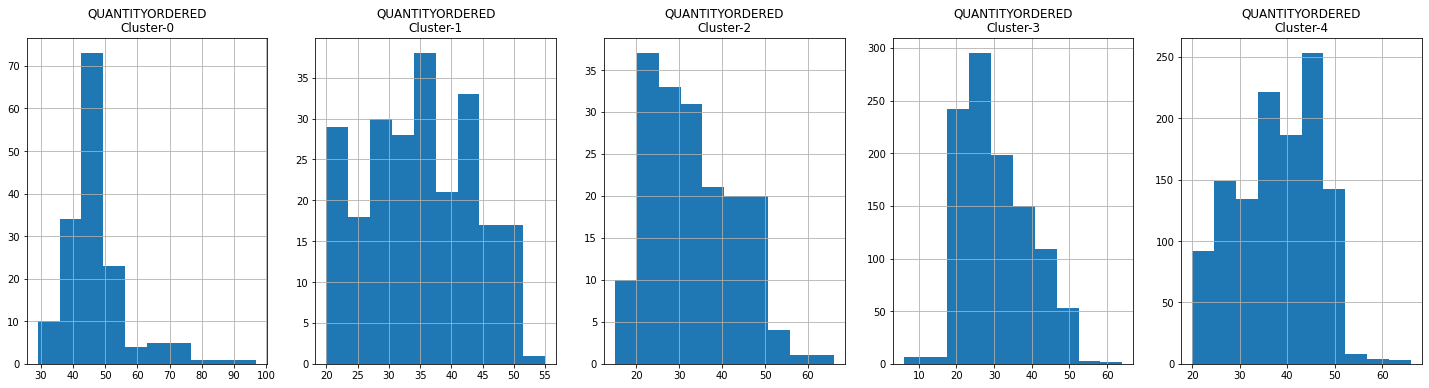

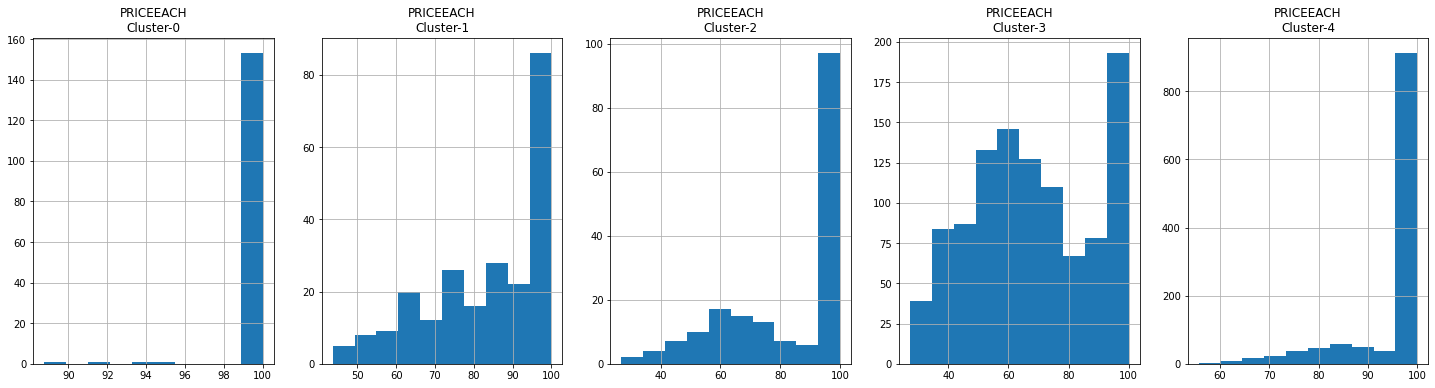

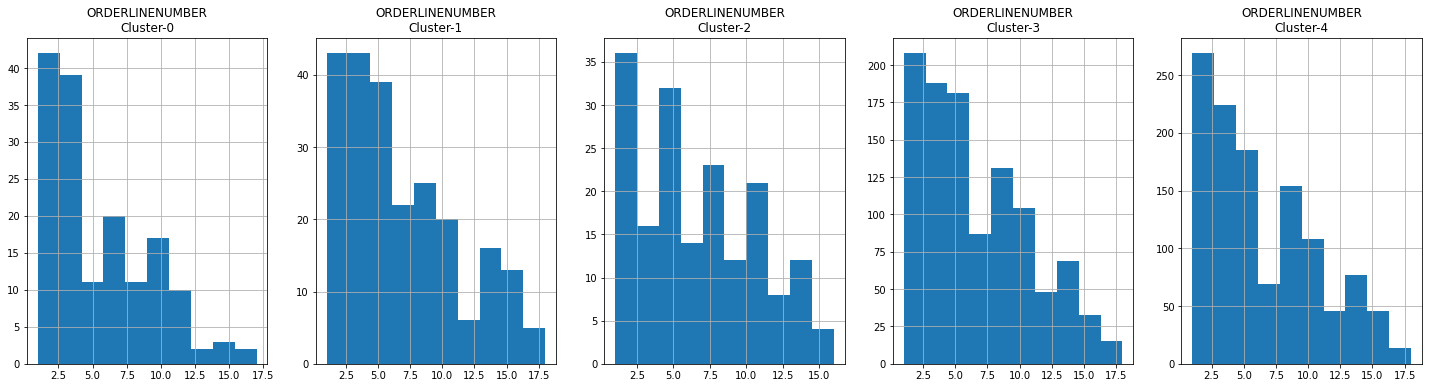

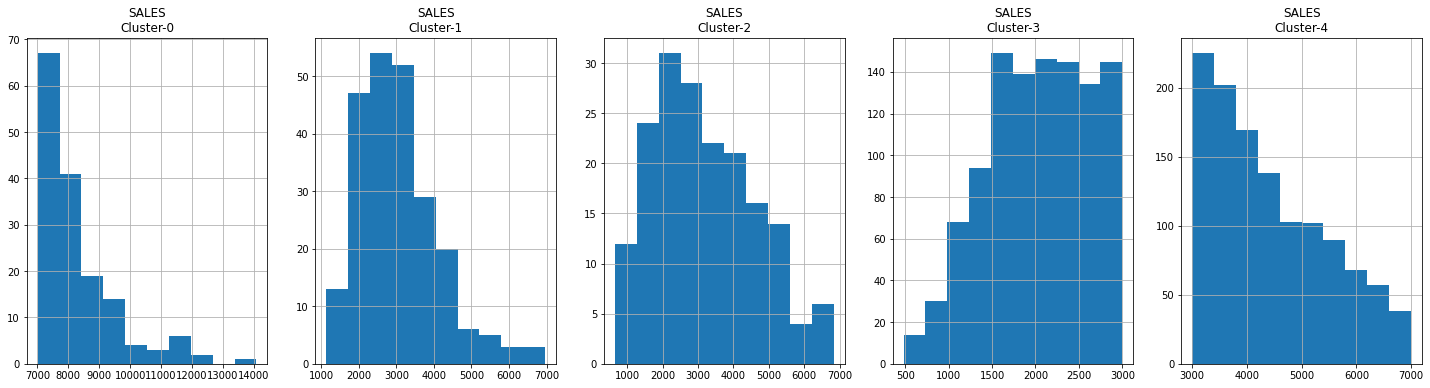

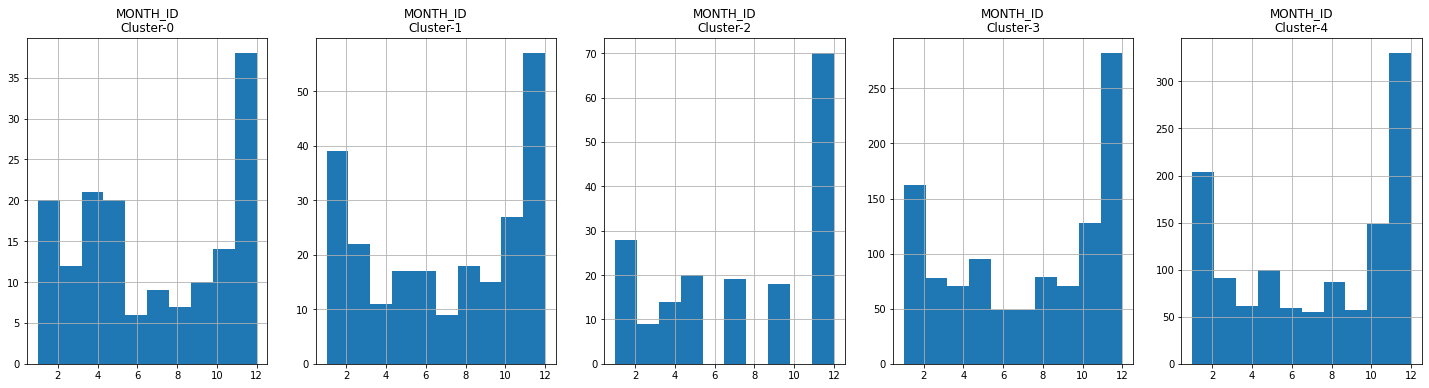

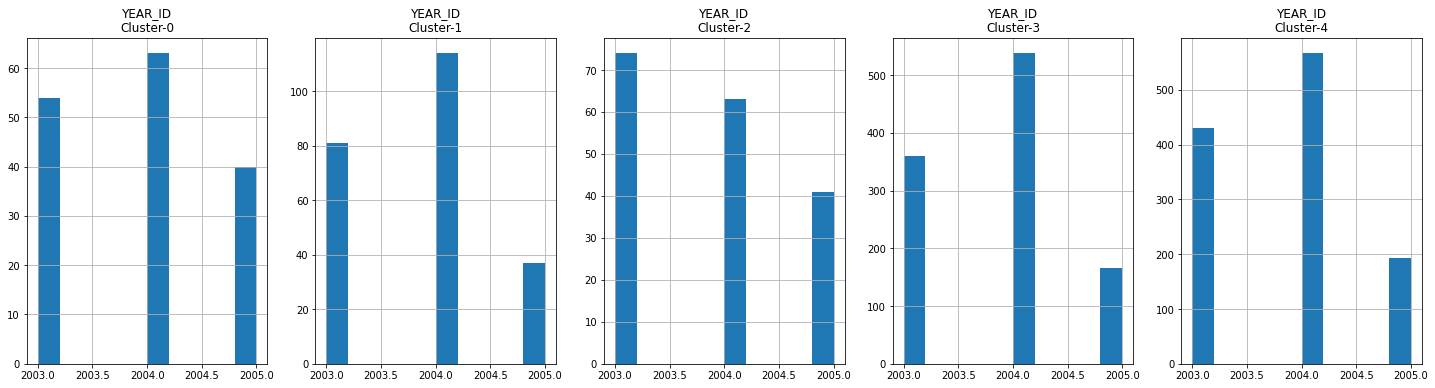

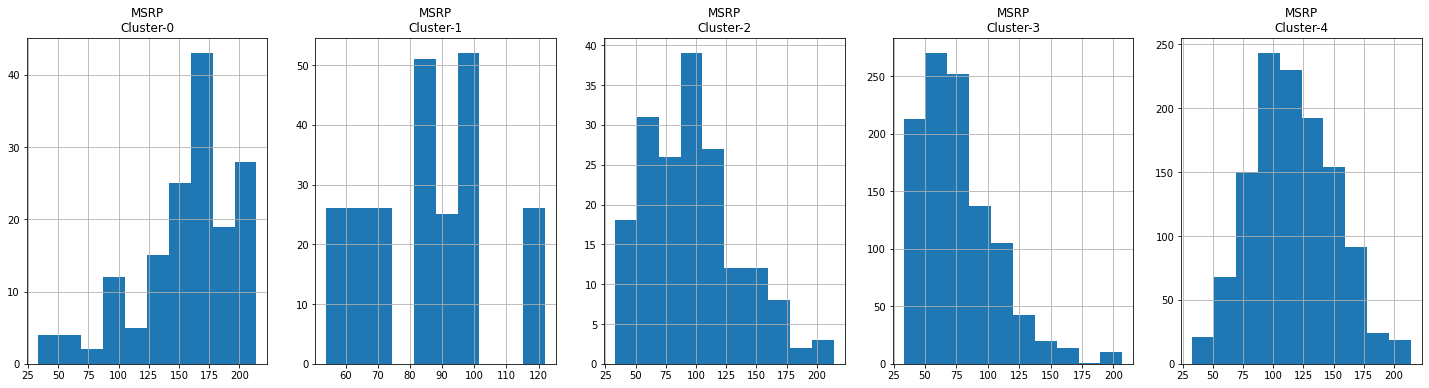

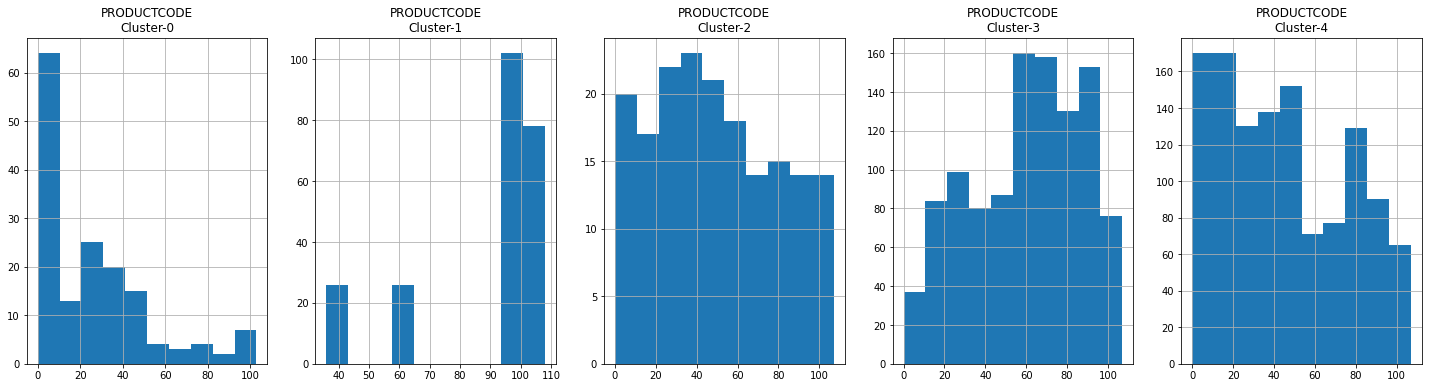

In [67]:
# Plotting histogram based on cluster, to check the distribution among clusters
for i in sales.columns[:8]:
    plt.figure(figsize=(25,6))
    for j in range(5):
        plt.subplot(1,5,j+1)
        cluster = sales_cluster[sales_cluster['cluster']==j]
        cluster[i].hist()
        plt.title(f'{i}\nCluster-{j}')
    plt.show()

# Applying PCA inorder to get more accurate clusters

In [68]:
# Reduce the original data to 3 dimension using PCA for visualizing clusters
pca = PCA(n_components=3)
principal_comp = pca.fit_transform(scaled_sales)
principal_comp

array([[-0.48634005, -1.25960428,  0.94889683],
       [-0.78460406, -1.05168521,  1.46120873],
       [ 1.4315174 ,  0.09849228,  0.32402027],
       ...,
       [ 0.38989446,  4.10143201, -0.02956797],
       [-2.78885665,  2.39200054,  1.5874895 ],
       [-0.70547717,  3.32962214, -0.48110516]])

In [70]:
# creating a dataframe of prinical components
pca_df = pd.DataFrame(principal_comp, columns=['pca1','pca2','pca3'])
pca_df.head()

,pca1,pca2,pca3
0,-0.486340,-1.259604,0.948897
1,-0.784604,-1.051685,1.461209
2,1.431517,0.098492,0.324020
3,1.288462,-0.247229,-0.571247
4,1.976087,-0.143096,-0.999734


In [74]:
# Adding clusters to the pca dataframe so that we can visulize them
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis=1)
pca_df.head()

,pca1,pca2,pca3,cluster
0,-0.486340,-1.259604,0.948897,3
1,-0.784604,-1.051685,1.461209,3
2,1.431517,0.098492,0.324020,4
3,1.288462,-0.247229,-0.571247,4
4,1.976087,-0.143096,-0.999734,4


In [76]:
fig = px.scatter_3d(pca_df, x='pca1',
                    y='pca2', z='pca3',
                    color='cluster', symbol='cluster',
                    size_max=18, opacity=0.6)
fig.update_layout(margin=dict(l=0,r=0,b=0,t=0))

2D plot instead of 3d

In [78]:
pca2 = PCA(n_components=2)
principal_comp2 = pca2.fit_transform(scaled_sales)

pca_df2d = pd.DataFrame(principal_comp2, columns=['pca1','pca2'])
pca_df2d = pd.concat([pca_df2d, pd.DataFrame({'cluster':labels})], axis=1)
pca_df2d.head()

fig = px.scatter(pca_df2d, x='pca1',
                    y='pca2',
                    color='cluster', symbol='cluster',
                    size_max=10, opacity=0.6)
fig.update_layout(margin=dict(l=0,r=0,b=0,t=0))

# Using AutoEncoder for dimensionality reduction

In [79]:
sales.shape

(2823, 37)

we have 37 dimensions

In [80]:
# Creating the autoencoders
# glorot uniform initilizer: Rather than initializing random values for our weights, glorot uniform with initialize random weights which comes from a certain uniform distribution

input = Input(shape=(sales.shape[1]))
x = Dense(50, activation='relu')(input)
x = Dense(500, activation='relu', kernel_initializer='glorot_uniform')(x)
x = Dense(500, activation='relu', kernel_initializer='glorot_uniform')(x)
x = Dense(2000, activation='relu', kernel_initializer='glorot_uniform')(x)
encoded = Dense(8, activation='relu', kernel_initializer='glorot_uniform')(x)

x = Dense(2000, activation='relu', kernel_initializer='glorot_uniform')(encoded)
x = Dense(500, activation='relu', kernel_initializer='glorot_uniform')(x)
decoded = Dense(37, activation='relu', kernel_initializer='glorot_uniform')(x) 

# AutoEncoder
autoencoder = Model(input, decoded)

# Encoder - Used for dimensionality reduction
encoder = Model(input, encoded)

autoencoder.compile(optimizer='adam', loss='mse')

Fitting the encoder

In [82]:
# In auto encoder we give same input and output
autoencoder.fit(sales, sales, batch_size=128,epochs=100,verbose=3)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

In [83]:
autoencoder.save_weights('autoencoder_weights.h5')

Grabbing predictions from the encoder

In [84]:
pred = encoder.predict(scaled_sales)

Finding the right k using elbow method

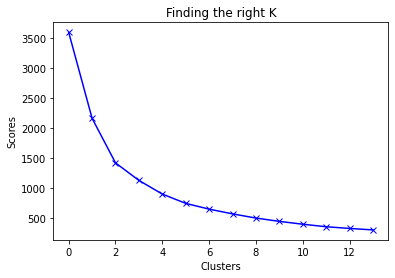

In [85]:
# Elbow method
scores = []

# from k=1 to k=15
for i in range(1,15):
    kmeans = KMeans(n_clusters=i) #creating KMeans object
    kmeans.fit(pred) # Fitting kmeans to scaled dataset
    # Inertia is the sum of squares distances within clusters
    scores.append(kmeans.inertia_) #store the inertias in scores

plt.plot(scores, 'bx-')
plt.title('Finding the right K')
plt.xlabel('Clusters')
plt.ylabel('Scores')
plt.show();    

Now, this time we can surely apply elbow method.
Taking k=3

In [86]:
# Cluster the data using K-means with K=5
kmeans = KMeans(3)
kmeans.fit(pred)
labels = kmeans.labels_

In [89]:
y_means = kmeans.fit_predict(scaled_sales)
cluster_df = pd.concat([sales, pd.DataFrame({'cluster':labels})], axis=1)
cluster_df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small,cluster
0,30,95.70,2.0,2871.00,2,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0
1,34,81.35,5.0,2765.90,5,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,41,94.74,2.0,3884.34,7,2003,95,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,45,83.26,6.0,3746.70,8,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
4,49,100.00,14.0,5205.27,10,2003,95,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0


In [91]:
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(cluster_centers,
                               columns=[sales.columns])
cluster_centers.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Large,Medium,Small
0,37.947254,95.361741,6.420520,4398.433699,7.104769,2003.806358,115.848988,48.545520,0.062139,0.020954,1.083815e-02,0.023844,0.022399,0.033237,0.107659,0.021676,0.004335,0.031792,0.015173,0.030347,0.010116,0.027457,0.123555,0.022399,1.589595e-02,0.051301,0.364884,0.382948,0.112717,0.093208,7.731214e-02,0.018786,0.126445,0.188584,-5.273559e-16,1.000000e+00,-8.715251e-15
1,30.525741,69.047496,6.649766,2061.682800,7.118565,2003.812793,77.340094,62.788612,0.071763,0.017161,1.404056e-02,0.028081,0.020281,0.031981,0.112324,0.021841,0.006240,0.048362,0.021841,0.029641,0.008580,0.028861,0.120125,0.018721,7.020281e-03,0.053822,0.339314,0.265211,0.121685,0.131045,9.906396e-02,0.039002,0.092824,0.251170,-1.595946e-16,-1.054712e-15,1.000000e+00
2,47.222930,99.799554,5.369427,8293.753248,6.770701,2003.910828,158.184713,26.242038,0.044586,0.025478,-1.908196e-17,0.006369,0.038217,0.031847,0.133758,0.025478,0.012739,0.044586,0.019108,0.031847,0.006369,0.025478,0.108280,0.012739,4.336809e-17,0.025478,0.407643,0.617834,0.121019,0.057325,-1.110223e-16,0.006369,0.044586,0.152866,1.000000e+00,-7.771561e-16,9.992007e-16


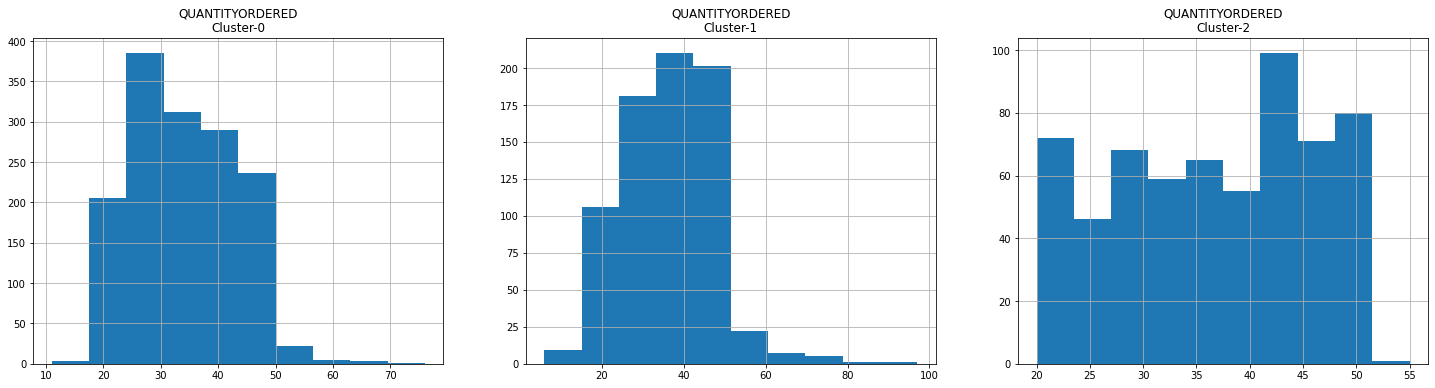

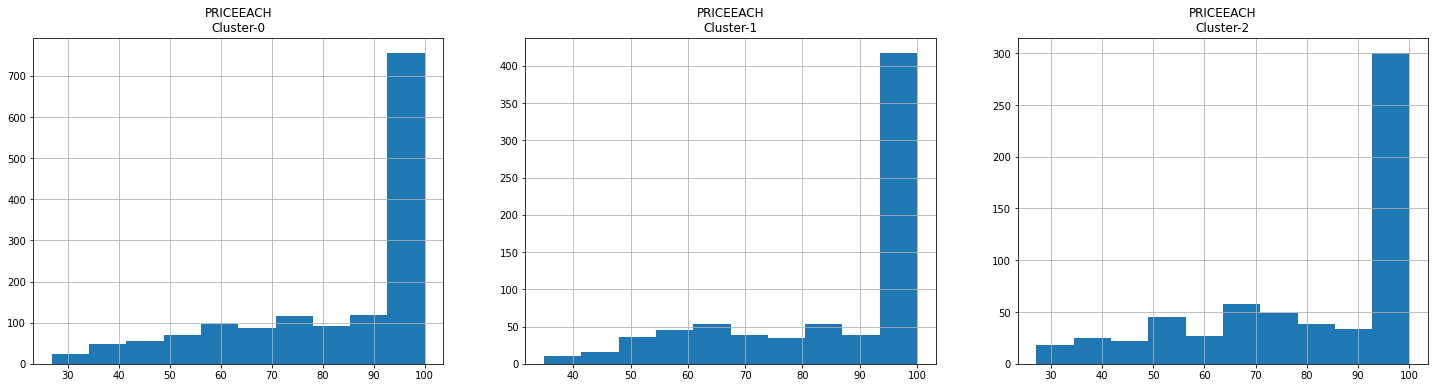

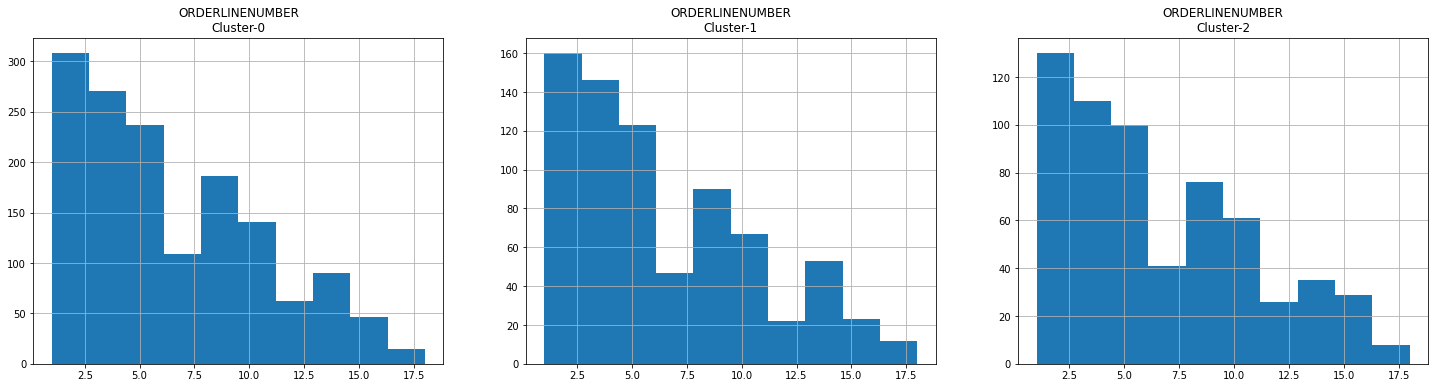

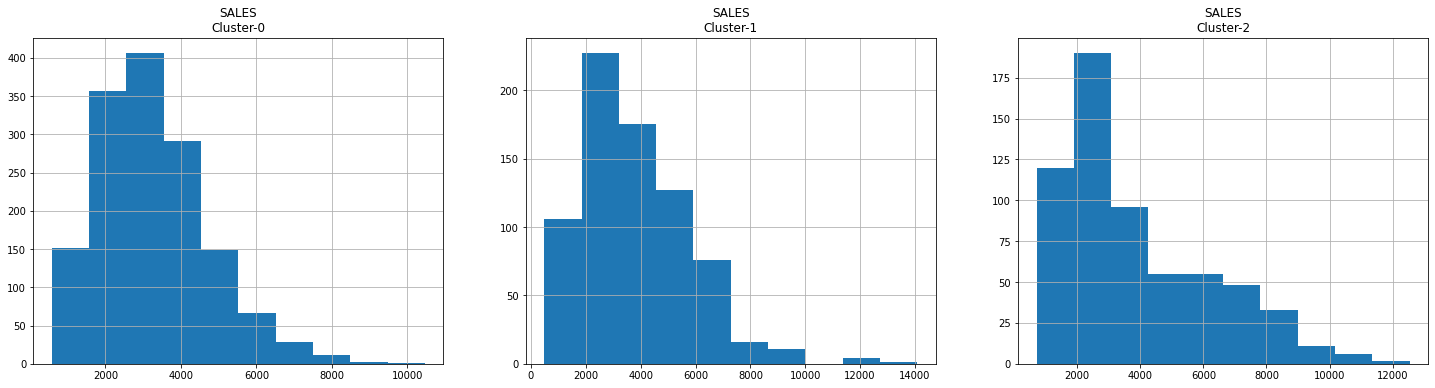

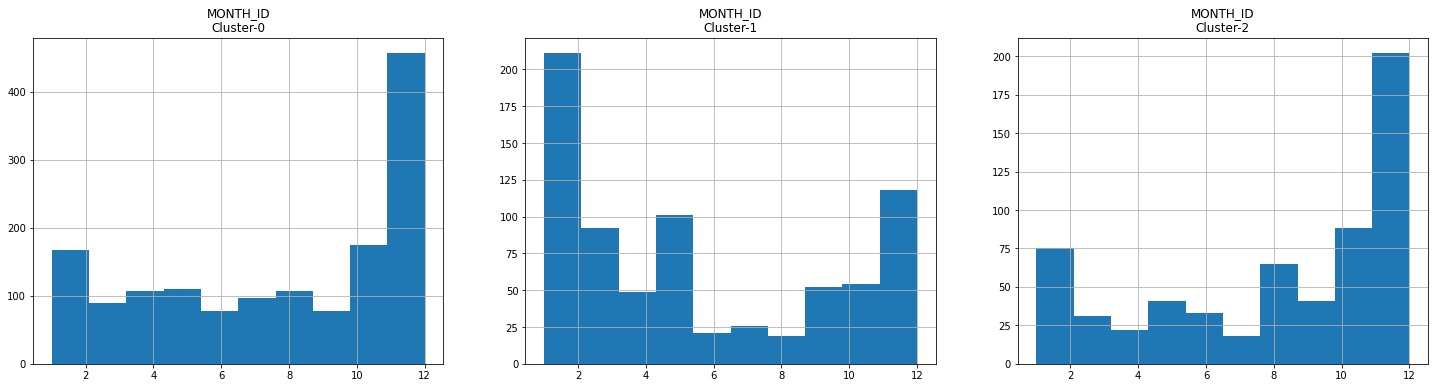

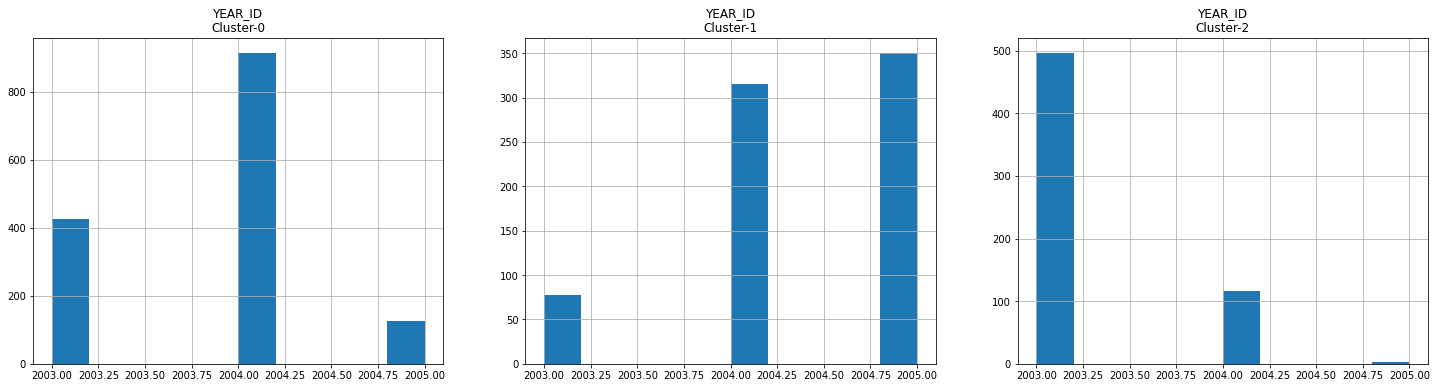

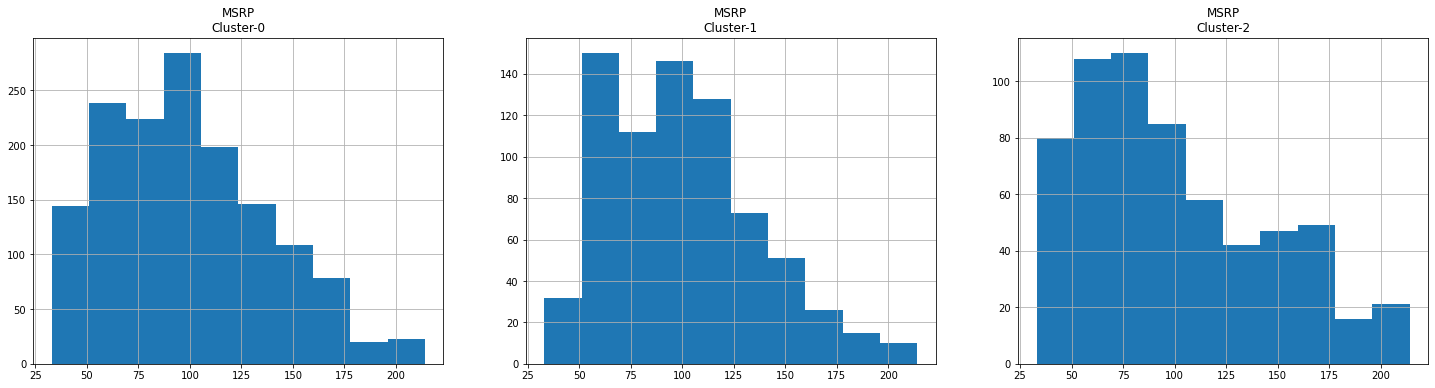

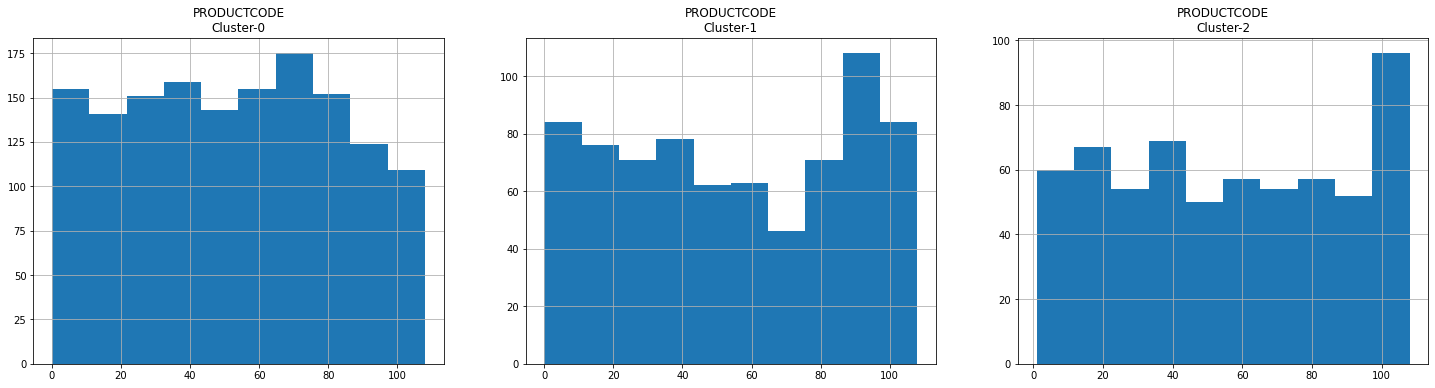

In [93]:
# Plotting histogram based on cluster, to check the distribution among clusters
for i in sales.columns[:8]:
    plt.figure(figsize=(25,6))
    for j in range(3):
        plt.subplot(1,3,j+1)
        cluster = cluster_df[cluster_df['cluster']==j]
        cluster[i].hist()
        plt.title(f'{i}\nCluster-{j}')
    plt.show()

In [94]:
# PCA for 3 dimensions
pca = PCA(n_components=3)
principal_comps = pca.fit_transform(scaled_sales)
pca_df = pd.DataFrame(data=principal_comps, columns=['pca1','pca2','pca3'])
pca_df.head()

,pca1,pca2,pca3
0,-0.486334,-1.179267,0.983484
1,-0.784600,-1.022151,1.432374
2,1.431493,0.154287,0.308749
3,1.288395,-0.191161,-0.579190
4,1.976023,-0.137005,-1.063983


In [96]:
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis=1)
pca_df.head()

,pca1,pca2,pca3,cluster
0,-0.486334,-1.179267,0.983484,0
1,-0.784600,-1.022151,1.432374,0
2,1.431493,0.154287,0.308749,0
3,1.288395,-0.191161,-0.579190,0
4,1.976023,-0.137005,-1.063983,0


In [98]:
fig = px.scatter_3d(pca_df, x='pca1',
                    y='pca2',z='pca3',
                    color='cluster',
                    size_max=10, opacity=.7)
fig.update_layout(margin=dict(l=0, r=0,b=0,t=0))

**Summary:**  
    1. performed EDA on the data.  
    2. Cleaned the data
    3. Used plotly to create visualizations . 
    4. Understood Kmeans clustering algorithms.    
    5. Performed Kmeans clustering on data.  
    6. Did dimensionality reduction PCA.  
    7. Created an AutoEncoder to do the dimensionality reduction.  
    8. Using autoencoder, found new clusters using kmeans elbow method.    
    9. Created 3d visualizations for final clusters.  

